# Annif Fusion experiment

**Osma Suominen, October 2018 / January 2019 (VW) / September 2019 (Keras NN)**

This notebook is an experiment for evaluating different methods to combine results of multiple subject indexing algorithms. We will use a document collection where gold standard subjects have been manually assigned and compare the subjects assigned by three different algorithm first individually, then in combinations created by different fusion approaches. In particular, we will test simple mean-of-subject-scores and union-of-top-K approaches as well as more advanced methods such as score normalization, isotonic regression and Learning to Rank style machine learning. Ideally, we would like to find a method for combining results from multiple algorithm that gives us the best quality results, combining the strengths of individual algorithms (both statistical/associative and lexical) while eliminating the effects of their weaknesses. The findings will then inform the further development of Annif.

The experiment was inspired by the Martin Toepfer's paper [Fusion architectures for automatic subject indexing under concept drift](https://link.springer.com/article/10.1007/s00799-018-0240-3) as well as discussions with him during and after the NKOS2018 workshop.

If you want to run this yourself, you need Python 3.5+ with the following libraries:

* jupyter (obviously)
* scikit-learn
* vowpalwabbit
* keras and tensorflow (for the neural network models)
* pyltr
* matplotlib (for the final plots)
* hyperopt (for the Learning to Rank hyperparameter search)

This document is (c) Osma Suominen. It may be shared and reused according to the terms of the [CC Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/) license. Attribution should include the name of the author and a link to the original source document. However, code snippets in this notebook may be freely reused according to the [CC0 1.0 Universal](https://creativecommons.org/publicdomain/zero/1.0/) license. Attribution for code is requested but not required.

## Document corpora

We will use two corpora for the experiment.

1. The ["Ask a Librarian" document corpus](https://github.com/NatLibFi/Annif-corpora/tree/master/fulltext/kirjastonhoitaja) contains 3150 short question-answer pairs in Finnish language. The collection is subdivided into three subsets: train (n=2625), validate (n=213) and test (n=312).   Librarians have assigned at least 4 subjects per document; the average is 4.4-4.8 subjects per document, depending on the subset.

2. The [JYU Theses document corpus](https://github.com/NatLibFi/Annif-corpora/tree/master/fulltext/jyu-theses) contains 5187 Finnish language Master's and doctoral theses from the University of Jyväskylä, published in the years 2010 to 2017. The collection is likewise subdivided to train (n=3635), validate (n=786) and test (n=766) subsets. There are around 5.9 gold standard subjects per document.

All documents in both collections have been assigned gold standard subjects by librarians, stored in `*.tsv` files where the basenames correspond to the original `*.txt` files (which are not read by this code at all and are not included in this repository). 

All the final evaluations will be performed on the test sets, which contain the most recent questions asked during the year 2017 and theses published in the year 2017, respectively. However, for some of the fusion methods we will make use of the train and validate subsets in order to fine-tune the way results are combined.

In addition, the documents have been analyzed using the [Annif](https://github.com/NatLibFi/Annif/) tool (development version v0.31.0) using three independent automated subject indexing algorithms: TF-IDF vector similarity, fastText and Maui, asking each algorithm to suggest up to 1000 subjects per document (however, we will in practice only load a fraction of these) with scores ranging from 1.0 to 0.0 given to each suggested subject. The subjects suggested by these algoritms are stored, respectively, in `*.tfidf`, `*.fasttext` and `*.maui` files.

First we load some basic modules and define the locations of the data files.

In [1]:
import pyltr
import os
import os.path
import glob
import numpy as np

# Select the dataset to use for the analysis by uncommenting one of these lines
ds = 'kirjastonhoitaja' # Ask a Librarian dataset
#ds = 'jyu-theses-fin'   # JYU Theses dataset

SUBJECTFILE='data/yso.tsv'
TRAIN_DIR='data/{}/train/'.format(ds)
VALI_DIR='data/{}/validate/'.format(ds)
TEST_DIR='data/{}/test/'.format(ds)
FILE_SIZES='data/{}/file-sizes.txt'.format(ds)

# define the number of concepts for which to calculate F1 score; this varies by dataset
F1_LIMIT = {'kirjastonhoitaja': 5, 'jyu-theses-fin': 6}

ALGORITHMS = ('tfidf','fasttext','maui')  # these correspond to file extensions

## Subject vocabulary

All the subjects have been chosen from the General Finnish Ontology YSO, which contains around 28000 concepts.
Here we load the vocabulary from a TSV file where the first column is the concept URI, the second column is the number of training documents collected from the Finna.fi corpus and used to train the tf-idf and fastText algorithms, and the third column is the concept label in Finnish. This has been extracted from the full YSO SKOS file and combined with frequencies from the YSO-Finna corpus.

Hereafter we will only use integer concept IDs which range from 0 to (n_concepts-1). All calculations are performed using the concept IDs so we just need to map the concept URIs which appear in files to their IDs.

In addition, we store the concept labels for later use as features for the Learning to Rank algorithm.

In [2]:
uri_to_cid = {}
subject_label = {}
subject_freq_finna = []
with open(SUBJECTFILE) as subjf:
    for cid, line in enumerate(subjf):
        uri, freq, label = line.strip().split("\t")
        uri_to_cid[uri] = cid
        subject_freq_finna.append(int(freq))
        subject_label[cid] = label
n_concepts = len(uri_to_cid)
print("Vocabulary loaded with", n_concepts, "concepts")

Vocabulary loaded with 27760 concepts


## Document corpus

We define a function to load the data from a directory of files in the format explained above. To be able to use both `scikit-learn` and `pyltr` libraries, we will need to express the data in two somewhat different formats, both based on multidimensional NumPy arrays:
    
1. pyltr ranking format, where the NumPy array rows correspond to document-subject pairs, i.e. there are multiple rows per document, one row per subject that has been suggested by at least one algorithm. A separate qids array ("query IDs", actually document IDs when applied this way) maps the document-subject pairs to the individual documents.
2. scikit-learn multilabel format, where the NumPy array has one row per document and the columns are individual concepts (either True/False for the gold standard subjects, or subject scores for the predicted subjects)

We will define this function once and then use it to parse all three document subsets (train, validate, test). We will only load up to 50 suggested subjects per document (amount selected by the `max_pred` parameter) to keep the size of the rankings manageable.

In [3]:
%%time

def load_data(directory, max_pred=50):
    """Reads document corpus with gold standard and predicted subjects for each document.
    Only the top max_pred predictions per document and algorithm are considered for ranking.
    Returns a tuple with
     - predictions of individual algorithms as a 2D NumPy array with the shape (doc-suggestions, n_algos)
     - relevant (gold standard) concepts as a 1D NumPy array with the shape (doc-suggestions)
     - qids (actually document ids) as a 1D NumPy array with length doc-suggestions
     - concept IDs of suggested concepts as a 1D NumPy array with shape (doc-suggestions)
     - gold standard subjects in sklearn multilabel format as a 2D NumPy array with shape (n_docs, n_concepts) 
     - predictions of individual algorithms in sklearn multilabel format as a 3D NumPy array with shape (n_docs, n_concepts, n_algos)
    """
    
    # temporary lists to be converted into NumPy arrays at the end
    docdatalist = []
    docscorelist = []
    docgoldlist = []
    doctruelist = []
    qidlist = []
    cidlist = []
    
    for tsvfilename in glob.glob(os.path.join(directory, '*.tsv')):
        basename = tsvfilename[:-4]
        
        # Initialize binary mask containing the top max_pred concepts that were suggested by any algorithm.
        # This will be used to pare down the doc-suggestions for ranking so that we will skip concepts
        # that were not suggested by any algorithm. They will still be considered in F1 score evaluation,
        # which is not based only on the ranked suggestions but used the full gold standard subjects.
        mask = np.zeros(n_concepts, dtype=np.bool)

        docdata = np.zeros((n_concepts, len(ALGORITHMS)))
        for algoid, fileext in enumerate(ALGORITHMS):
            with open(basename + "." + fileext) as algooutput:
                lines = 0
                for lineno, line in enumerate(algooutput):
                    uri, _, score = line.strip().split("\t")
                    if uri not in uri_to_cid:
                        continue  # ignore unknown URIs
                    cid = uri_to_cid[uri]
                    docdata[cid,algoid] = float(score)
                    if lineno < max_pred:
                        mask[cid] = True
        docdatalist.append(docdata[mask])
        docscorelist.append(docdata)
    
        docgold = np.zeros(n_concepts, dtype=np.bool)
        with open(tsvfilename) as tsvfile:
            for line in tsvfile:
                uri = line.split("\t")[0]
                if uri in uri_to_cid:
                    cid = uri_to_cid[uri]
                    docgold[cid] = True
        docgoldlist.append(docgold[mask])
        doctruelist.append(docgold)
        
        fileid = int(basename.split('/')[-1].split('-')[-1])
        qidlist.append(np.full(mask.sum(), fileid))
        cidlist.append(np.arange(n_concepts)[mask])

    return np.concatenate(docdatalist), np.concatenate(docgoldlist), np.concatenate(qidlist), \
           np.concatenate(cidlist), np.array(doctruelist), np.array(docscorelist)

# now load the train, validate and test documents
TX, Ty, Tqids, Tcids, Ttrue, Tscores = load_data(TRAIN_DIR)
VX, Vy, Vqids, Vcids, Vtrue, Vscores = load_data(VALI_DIR)
EX, Ey, Eqids, Ecids, Etrue, Escores = load_data(TEST_DIR)

# Show some information about the shapes
print("TX shape:", TX.shape)
print("Ty shape:", Ty.shape)
print("Tqids shape:", Tqids.shape)
print("Tcids shape:", Tcids.shape)
print("Ttrue shape:", Ttrue.shape)
print("Tscores shape:", Tscores.shape)
print()
print("VX shape:", VX.shape)
print("Vy shape:", Vy.shape)
print("Vqids shape:", Vqids.shape)
print("Vcids shape:", Vcids.shape)
print("Vtrue shape:", Vtrue.shape)
print("Vscores shape:", Vscores.shape)
print()
print("EX shape:", EX.shape)
print("Ey shape:", Ey.shape)
print("Eqids shape:", Eqids.shape)
print("Ecids shape:", Ecids.shape)
print("Etrue shape:", Etrue.shape)
print("Escores shape:", Escores.shape)

TX shape: (283089, 3)
Ty shape: (283089,)
Tqids shape: (283089,)
Tcids shape: (283089,)
Ttrue shape: (2625, 27760)
Tscores shape: (2625, 27760, 3)

VX shape: (22604, 3)
Vy shape: (22604,)
Vqids shape: (22604,)
Vcids shape: (22604,)
Vtrue shape: (213, 27760)
Vscores shape: (213, 27760, 3)

EX shape: (33318, 3)
Ey shape: (33318,)
Eqids shape: (33318,)
Ecids shape: (33318,)
Etrue shape: (312, 27760)
Escores shape: (312, 27760, 3)
CPU times: user 14.1 s, sys: 2.92 s, total: 17 s
Wall time: 18.7 s


## Evaluation metrics

For evaluating the quality of results, we will use two metrics: [NDCG](https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG) which is based on ranked suggestions (if the top ranked suggestion is correct it will contribute more to the score than getting the 2nd or 3rd suggestion right) and [F1 score](https://en.wikipedia.org/wiki/F1_score) that only considers binary choices: either a concept is a subject of a document or it is not, there are no fuzzy options. 

For the **NDCG score**, we can simply use the implementation from the `pyltr` library. Here we limit the NDCG evaluation to the top 20 most highly ranked subjects (i.e. NDCG@20), meaning that subjects ranked 21st, 22nd etc won't contribute to the score (their effect would be quite small anyway do to the discounting performed in NDCG calculations).

For the **F1 score**, we can use the `scikit-learn` implementation. However, its usage is complicated by the fact that we are mostly dealing with ranked suggestions in the pyltr format, so we need to convert those into the multilabel prediction format understood by scikit-learn and further binarize the predictions using a thresholding strategy. For simplicity we will pick the top K suggested concepts (where K varies by dataset), so we get an amount of subjects that is similar to the librarian-assigned ones, and compare those to the gold standard. The score for each document will be calculated individually and the final result will be the average of those scores (i.e. sample based average).

Finally, we will define an evaluation function that is given ranked suggestions as well as gold standard subjects (in both pyltr and scikit-learn formats) and some auxiliary information (qids and cids). It will calculate both NDCG and F1 score, print them out, and also return the scores so that they can be stored for later plotting etc.

In [4]:
import collections
from sklearn.metrics import f1_score

# initialize the NDCG metric implementation
ndcg_metric = pyltr.metrics.NDCG(k=20)

def ranking_to_multilabel(pred, qids, cids):
    """convert from pyltr ranking prediction format to sklearn multilabel prediction format"""
    doc_labels = collections.OrderedDict()  # key: qid, val: NumPy 1D array with length n_concepts
    for score, qid, cid in zip(pred, qids, cids):
        if qid not in doc_labels:
            doc_labels[qid] = np.zeros(n_concepts)
        doc_labels[qid][cid] = score
    return np.array(list(doc_labels.values()))

def binarize_multilabel_pred(pred, k=5):
    """convert predictions with scores to a boolean matrix, taking the top K predictions per document"""
    # I'm pretty sure this could be done easier, perhaps in a single NumPy operation, but I can't figure it out
    # Using a loop instead, it's not going to take long anyway
    binary_labels = np.zeros(pred.shape, dtype=np.bool)
    pred_order = pred.argsort()[:,::-1]
    for i, mask in enumerate(pred_order[:,:k]):
        binary_labels[i,mask] = True
    return binary_labels & (pred > 0.0)  # make sure not to include predictions with 0.0 score

def evaluate(name, qids, y, y_true, pred, cids):
    """evaluate a ranking, calculating its NDCG and F1 score. Print and return the scores"""
    # calculate NDCG score
    ndcg = ndcg_metric.calc_mean(qids, y, pred)

    # calculate F1 score
    pred_labels = ranking_to_multilabel(pred, qids, cids)
    f1 = f1_score(y_true, binarize_multilabel_pred(pred_labels, k=F1_LIMIT[ds]), average='samples')
    
    print("{:<18} {:>20}:\tNDCG={:.4f}\tF1@{}={:.4f}".format(ds, name, ndcg, F1_LIMIT[ds], f1))
    return ndcg, f1


# initialize dictionary for collecting evaluation results
eval_results = collections.defaultdict(collections.OrderedDict)

## Baseline evaluation

Now we are ready for some baseline evaluations: we can evaluate the individual algorithms as well as a simplistic combination method using the mean of assigned scores (the only one implemented in Annif v0.31.0) as well as variations like geometric mean and maximum. We will store the results for later too.

In [5]:
import scipy.stats

# evaluate the individual algorithms
for algoid, name in enumerate(ALGORITHMS):
    eval_results[ds][name] = evaluate(name, Eqids, Ey, Etrue, EX[:,algoid], Ecids)

# evaluate the combination of algorithms using mean of scores
eval_results[ds]["mean"] = evaluate("mean", Eqids, Ey, Etrue, EX.mean(1), Ecids)

# evaluate the combination of algorithms using geometric mean of scores
eval_results[ds]["gmean"] = evaluate("gmean", Eqids, Ey, Etrue, scipy.stats.gmean(EX, axis=1), Ecids)

# evaluate the combination of algorithms using maximum of scores
eval_results[ds]["max"] = evaluate("max", Eqids, Ey, Etrue, EX.max(1), Ecids)

kirjastonhoitaja                  tfidf:	NDCG=0.4223	F1@5=0.2220
kirjastonhoitaja               fasttext:	NDCG=0.2737	F1@5=0.1329
kirjastonhoitaja                   maui:	NDCG=0.5133	F1@5=0.2949
kirjastonhoitaja                   mean:	NDCG=0.5701	F1@5=0.3142


/home/oisuomin/.local/share/virtualenvs/Annif-fusion-qoC3HCDa/lib/python3.5/site-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


kirjastonhoitaja                  gmean:	NDCG=0.4993	F1@5=0.3100
kirjastonhoitaja                    max:	NDCG=0.5238	F1@5=0.2925


We can see that out of individual algorithms, Maui performed best, followed by TF-IDF and fastText. The mean of scores gave better results than any algorithm alone. The NDCG and F1 measures seem to agree on which methods are better than others, as they both ranked the methods in the same order.

Note that the F1 scores may seem quite low (in some classification tasks F1 scores of 0.95 and more are not uncommon), but keep in mind that the task given to the algorithms is quite difficult: for each document, it should pick the 5 subjects (out of nearly 28000) that best describe that document. There are numerous ways of getting this wrong and only a few ways of picking a good set of subjects. So even a rather low F1 score of 0.2 means that around one out of five subjects was right - much better than chance.

## Union of top K concepts

Let's try a variation of averaging the scores of the different algorithms. This time we only pick the top K subjects (where K is a small number, e.g. 2 or 3) suggested by each algorithm and use their union as the suggested concepts. We will still take the mean of scores in order to rank the results (otherwise the NDCG score would not be well defined as it requires the results to have some stable ranking order) but will drastically reduce the number of subjects being considered.

This is a bit challenging to implement within the ranked suggestions format of pyltr, so what we will do instead is to implement it using sklearn multilabel prediction format and then convert that to a list of ranking predictions using the qids and cids information.

In [6]:
def multilabel_to_ranking_preds(scores, qids, cids):
    """convert a sklearn multilabel prediction to pyltr ranking according to the given qids and cids"""
    
    qid_to_docid = collections.OrderedDict()
    for qid in qids:
        if qid not in qid_to_docid:
            qid_to_docid[qid] = len(qid_to_docid)
    return np.array([scores[qid_to_docid[qid],cid] for qid, cid in zip(qids, cids)])

def select_top_k(scores, k):
    mask = binarize_multilabel_pred(scores, k=k)
    return scores * mask

def union_of_top_k(scores, qids, cids, k):
    top_scores = np.zeros(scores.shape)
    for algoid in range(len(ALGORITHMS)):
        top_scores[:,:,algoid] = select_top_k(scores[:,:,algoid], k=k)
    
    preds_union = multilabel_to_ranking_preds(top_scores, qids, cids)
    name = "union-{}".format(k)
    eval_results[ds][name] = evaluate(name, Eqids, Ey, Etrue, preds_union.mean(1), Ecids)

for k in (1,2,3,5,10,20,40):
    union_of_top_k(Escores, Eqids, Ecids, k)

kirjastonhoitaja                union-1:	NDCG=0.3026	F1@5=0.2289
kirjastonhoitaja                union-2:	NDCG=0.3988	F1@5=0.2672
kirjastonhoitaja                union-3:	NDCG=0.4410	F1@5=0.2773
kirjastonhoitaja                union-5:	NDCG=0.5091	F1@5=0.2947
kirjastonhoitaja               union-10:	NDCG=0.5588	F1@5=0.3036
kirjastonhoitaja               union-20:	NDCG=0.5560	F1@5=0.3053
kirjastonhoitaja               union-40:	NDCG=0.5635	F1@5=0.3096


The results were not encouraging. NDCG and F1 scores are generally lower than for the mean strategy. With higher K values, the results get closer to the ones for the mean method, which is expected since having a low limit on the number of results considered is the only aspect that differentiates this method from using just the mean of all scores.

## Normalization of prediction scores

Each algorithm returns its scores on the scale 0.0 to 0.1, but they may be using different ranges within that scale. Because of this, simple averaging of scores may cause one algorithm which tends to report high scores to have much more impact on the result than another one that uses low scores. We can counteract that by normalizing the scores before taking the mean of scores. `scikit-learn` implements several normalization methods: L1, L2 and max-value. Let's see if they have an effect on merging results.

In [7]:
from sklearn.preprocessing import normalize

for norm in ('l1', 'l2', 'max'):
    # we will have to perform the normalization separately for each algorithm's output
    Escores_norm = np.zeros(Escores.shape)
    for algoid in range(len(ALGORITHMS)):
        Escores_norm[:,:,algoid] = normalize(Escores[:,:,algoid], norm=norm)
    Epreds_norm = multilabel_to_ranking_preds(Escores_norm, Eqids, Ecids)
    eval_results[ds]["mean-" + norm] = evaluate("mean-" + norm, Eqids, Ey, Etrue, Epreds_norm.mean(1), Ecids)

kirjastonhoitaja                mean-l1:	NDCG=0.5489	F1@5=0.3095
kirjastonhoitaja                mean-l2:	NDCG=0.5544	F1@5=0.2991
kirjastonhoitaja               mean-max:	NDCG=0.5526	F1@5=0.2941


This does not seem to help much either. All normalization methods give similar results as the mean method, or worse.

## PAV aka Isotonic Regression

The effectiveness of each algorithms varies by concept. Some concepts are given higher scores than they should, which results in false positives. Others are given too low scores, resulting in false negatives. We can try to correct some of this bias using a statistical method called isotonic regression, also known as Pool Adjacent Violators (PAV). The idea is to assess the scores given to individual concepts for a document against the likelihood that the concept was among the gold standard subjects of that document. The resulting models (separate models per concept and algorithm), initialized on training data, will then be able to convert raw scores returned by the algorithm to probabilities of the concept being correct. The resulting probabilities are then all on the same scale (0.0 to 0.1) which makes it easy to compare and combine them.

One complication is that the frequency distribution of concepts in any training set is likely to be very skewed. Many concepts don't appear at all in training data. Others appear only a few times. We must decide when we have enough examples of a concept to be able to create an isotonic regression model.

When applying the regression models on actual data, how to handle concepts for which we don't have a regression model is a problem. In this case we will simply use the raw, untransformed scores.

We will try different variations of isotonic regression to see if they help improve the overall performance.

In [8]:
%%time
from sklearn.isotonic import IsotonicRegression

def build_reg_models(k, limit=None):
    """build a dictionary of regression models based on training documents. Models will only be created for concepts with a minimum of K true instances in the training data."""

    if limit is not None:
        idx = np.random.randint(Tscores.shape[0], size=limit)
        scores = Tscores[idx]
        true = Ttrue[idx]
    else:
        scores = Tscores
        true = Ttrue
    
    reg_models = {}
    for cid in range(n_concepts):
        if Ttrue[:,cid].sum() >= k:
            for algoid in range(len(ALGORITHMS)):
                reg = IsotonicRegression(out_of_bounds="clip")
                reg.fit(np.concatenate((scores[:,cid,algoid], [0,1])), np.concatenate((true[:,cid], [0, 1])))
                reg_models[(algoid,cid)] = reg
    return reg_models

def reg_predict(reg_models, scores, algoid, fallback='raw'):
    reg_scores = np.zeros(scores.shape)
    for cid in range(n_concepts):
        reg_model = reg_models.get((algoid, cid))
        if reg_model is not None:
            reg_scores[:,cid] = reg_model.predict(scores[:,cid])
        elif fallback == 'raw':
            reg_scores[:,cid] = scores[:, cid] # use raw score
        elif fallback == 'nan':
            reg_scores[:,cid] = np.nan
        elif fallback == 'zero':
            # use zero scores if no model available
            pass
        else:
            print("Unknown fallback strategy", fallback)
    return reg_scores

def get_reg_rankings(reg_models, scores, qids, cids, fallback='raw'):
    scores_reg = np.zeros(scores.shape)
    for algoid in range(len(ALGORITHMS)):
        scores_reg[:,:,algoid] = reg_predict(reg_models, scores[:,:,algoid], algoid, fallback)
    return multilabel_to_ranking_preds(scores_reg, qids, cids)

for limit in (256,512,1024,2048,None):
    for k in (0,1,2,3,4,5,6,8,10):
        reg_models = build_reg_models(k,limit)
        Epreds_reg = get_reg_rankings(reg_models, Escores, Eqids, Ecids)
        name = "reg-{}-{}".format(k,limit)
        eval_results[ds][name] = evaluate(name, Eqids, Ey, Etrue, Epreds_reg.mean(1), Ecids)

kirjastonhoitaja              reg-0-256:	NDCG=0.6089	F1@5=0.3335
kirjastonhoitaja              reg-1-256:	NDCG=0.5842	F1@5=0.3241
kirjastonhoitaja              reg-2-256:	NDCG=0.6123	F1@5=0.3386
kirjastonhoitaja              reg-3-256:	NDCG=0.6065	F1@5=0.3391
kirjastonhoitaja              reg-4-256:	NDCG=0.5974	F1@5=0.3283
kirjastonhoitaja              reg-5-256:	NDCG=0.6129	F1@5=0.3444
kirjastonhoitaja              reg-6-256:	NDCG=0.6218	F1@5=0.3460
kirjastonhoitaja              reg-8-256:	NDCG=0.6304	F1@5=0.3582
kirjastonhoitaja             reg-10-256:	NDCG=0.6105	F1@5=0.3367
kirjastonhoitaja              reg-0-512:	NDCG=0.6165	F1@5=0.3347
kirjastonhoitaja              reg-1-512:	NDCG=0.5919	F1@5=0.3313
kirjastonhoitaja              reg-2-512:	NDCG=0.6152	F1@5=0.3367
kirjastonhoitaja              reg-3-512:	NDCG=0.6151	F1@5=0.3414
kirjastonhoitaja              reg-4-512:	NDCG=0.6270	F1@5=0.3370
kirjastonhoitaja              reg-5-512:	NDCG=0.6366	F1@5=0.3537
kirjastonhoitaja         

The results are quite a lot better than anything seen so far, indicating that isotonic regression can help improve the quality of fusion. There appears to be a sweet spot somewhere around 3-8 occurrences of concepts as the threshold value for when to apply isotonic regression.

# Regression using Vowpal Wabbit

Instead of PAV, we can try another regression method. The Vowpal Wabbit online learning system can be used in a similar fashion, but it has an additional benefit: it can continue learning after initial training, e.g. based on user feedback.

This approach is also similar to Learning to Rank (below).

In [9]:
%%time
from vowpalwabbit import pyvw
import random
import os
import os.path
import collections

TRAINFILE='vw-train'

if os.path.exists(TRAINFILE + '.cache'):
    os.unlink(TRAINFILE + '.cache')

rows_per_concept = collections.Counter()

# create a train file in VW format
with open(TRAINFILE, 'w') as trainf:
    ids = list(range(len(Ty)))
    random.shuffle(ids)
    for i in ids:
        if Ty[i]:
            val = 1
        else:
            val = -1
        row = "{} |{}".format(val, Tcids[i])
        for algoid, algoname in enumerate(ALGORITHMS):
            row += " {}:{}".format(algoname, TX[i][algoid])
        rows_per_concept[Tcids[i]] += 1
        print(row, file=trainf)

CPU times: user 3.22 s, sys: 71.2 ms, total: 3.29 s
Wall time: 3.33 s


In [10]:
%%time
# create a VW classifier

import math

def create_vw(passes):
    return pyvw.vw(data=TRAINFILE, q="::", b=21, passes=passes, cache_file=TRAINFILE + '.cache', loss_function='squared')

def concept_freq(cid):
    return rows_per_concept[cid]

def create_pred(vw, discount):
    preds = []
    for i in range(len(EX)):
        raw_weight = 1.0 / (discount * concept_freq(Ecids[i]) + 1)
        row = " |{}".format(Ecids[i])
        for algoid, algoname in enumerate(ALGORITHMS):
            row += " {}:{}".format(algoname, EX[i][algoid])  
        pred = (vw.predict(row) + 1.0) / 2.0
        raw = EX[i].mean()
        preds.append((raw * raw_weight) + (pred * (1 - raw_weight)))
    return np.array(preds)
    

for passes in (1,2,4,8):
    vw = create_vw(passes)
    for discount in (0.005, 0.01, 0.02, 0.04, 0.06, 0.08):
        name = "vw-{}-{}".format(passes, discount)
        preds = create_pred(vw, discount)
        eval_results[ds][name] = evaluate(name, Eqids, Ey, Etrue, preds, Ecids)

kirjastonhoitaja             vw-1-0.005:	NDCG=0.6710	F1@5=0.3629
kirjastonhoitaja              vw-1-0.01:	NDCG=0.6753	F1@5=0.3711
kirjastonhoitaja              vw-1-0.02:	NDCG=0.6729	F1@5=0.3654
kirjastonhoitaja              vw-1-0.04:	NDCG=0.6613	F1@5=0.3654
kirjastonhoitaja              vw-1-0.06:	NDCG=0.6535	F1@5=0.3571
kirjastonhoitaja              vw-1-0.08:	NDCG=0.6436	F1@5=0.3557
kirjastonhoitaja             vw-2-0.005:	NDCG=0.6704	F1@5=0.3733
kirjastonhoitaja              vw-2-0.01:	NDCG=0.6777	F1@5=0.3826
kirjastonhoitaja              vw-2-0.02:	NDCG=0.6725	F1@5=0.3790
kirjastonhoitaja              vw-2-0.04:	NDCG=0.6643	F1@5=0.3779
kirjastonhoitaja              vw-2-0.06:	NDCG=0.6560	F1@5=0.3694
kirjastonhoitaja              vw-2-0.08:	NDCG=0.6522	F1@5=0.3666
kirjastonhoitaja             vw-4-0.005:	NDCG=0.6732	F1@5=0.3686
kirjastonhoitaja              vw-4-0.01:	NDCG=0.6761	F1@5=0.3788
kirjastonhoitaja              vw-4-0.02:	NDCG=0.6718	F1@5=0.3773
kirjastonhoitaja         

With good hyperparameter choices, the results are as good or better than with PAV.

## Neural network ensembles

Let's try some modern neural network approach. We will use the Keras framework to build TensorFlow models. This isn't actually deep learning as the models are not very deep, but we will use the same tools.

First we need to define some basics. For example, it's good to have a way to measure NDCG and F1 after every epoch, not just at the end, so we need a custom callback. It would be even better to implement this as a custom Keras metric, but that would be more difficult, so we will only use top_k_categorical_accuracy metric which I think is the same as precision@K in this context.

In [12]:
from keras.callbacks import Callback

def eval_keras_model(name, model):
    # evaluate a Keras model using F1 and NDCG on test (evaluation) set
    scores = model.predict(Escores)
    preds = multilabel_to_ranking_preds(scores, Eqids, Ecids)
    eval_results[ds][name] = evaluate(name, Eqids, Ey, Etrue, preds, Ecids)
    
# custom Keras callback for measuring NDCG and F1 scores
class EvalCallback(Callback):
    def __init__(self, name):
        self._name = name
    
    def on_epoch_end(self, epoch, logs=None):
        eval_keras_model("{}/{}".format(self._name, epoch + 1), self.model)

Using TensorFlow backend.


### Simple weighted average using Conv1D

Let's start with a very simple model where the network calculates a simple weighted average of the concept scores and the weights are adjusted by the network. This can be accomplished using 1D convolution with the Conv1D class.

We will try two variations, one that uses bias terms and another without them.

In [15]:
from keras.layers import Input, Conv1D, Reshape
from keras.models import Model
from keras.initializers import Constant

def create_keras_conv1d(name, epochs=1, use_bias=True):
    inputs = Input(shape=(n_concepts,len(ALGORITHMS)))

    interim = Conv1D(1, 1, use_bias=use_bias, 
                     kernel_initializer=Constant(1.0/len(ALGORITHMS)))(inputs)
    predictions = Reshape((n_concepts,))(interim)

    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['top_k_categorical_accuracy'])
    print(model.summary())
    model.fit(Tscores, Ttrue, batch_size=32, verbose=True, epochs=epochs, callbacks=[EvalCallback(name)])

    print("trained conv1d weights:", list(model.layers[1].get_weights()))
    return model

for epochs in (10,):
    for use_bias in (True,False): # False):
        name = "conv1d-{}-{}".format(epochs, use_bias)
        model = create_keras_conv1d(name, epochs, use_bias)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 27760, 3)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27760, 1)          4         
_________________________________________________________________
reshape_1 (Reshape)          (None, 27760)             0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/10
2625/2625 [==============================] - 8s 3ms/step - loss: 9.5423e-04 - top_k_categorical_accuracy: 0.4404
kirjastonhoitaja       conv1d-10-True/1:	NDCG=0.5650	F1@5=0.3153
Epoch 2/10
2625/2625 [==============================] - 7s 3ms/step - loss: 9.6569e-04 - top_k_categori

That didn't work so well. I think the problem is that since there are only very few correct/true subjects per document, but many incorrect ones, the model has a hard time finding weights that work. 

### Hadamard weighting

Let's try another kind of weighting. We will apply a different weight factor for each of the concept predictions before averaging them. This could be done using LocallyConnected2D layer, but for some reason locally connected layers in Keras are very slow and memory-hungry (see [this issue](https://github.com/keras-team/keras/issues/10735)) we will instead implement a custom layer that applies a [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) on the input matrix and tries to optimize the weights to get the best results, starting from equal weights (all 1.0). The implementation is based on [this StackOverflow discussion](https://stackoverflow.com/questions/46821845/how-to-add-a-trainable-hadamard-product-layer-in-keras), only slightly modified. The averaging is done using a non-trainable Lambda layer with equal weights.

In [19]:
from keras.engine.topology import Layer
from keras.layers import Lambda
import keras.backend as K

class Hadamard(Layer):

    def __init__(self, **kwargs):
        super(Hadamard, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1,) + input_shape[1:],
                                      initializer='ones',
                                      trainable=True)
        super(Hadamard, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        #print(x.shape, self.kernel.shape)
        return x * self.kernel

    def compute_output_shape(self, input_shape):
        #print(input_shape)
        return input_shape

def create_keras_hadamard(name, epochs=1):

    # This returns a tensor
    inputs = Input(shape=(n_concepts,len(ALGORITHMS))
    biased = Hadamard()(inputs)
    predictions = Lambda(lambda x: K.mean(x, axis=2))(biased)

    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['top_k_categorical_accuracy'])
    print(model.summary())
    model.fit(Tscores, Ttrue, batch_size=32, verbose=True, epochs=epochs, callbacks=[EvalCallback(name)])

    return model

for epochs in (10,):
    name = "hadamard-{}".format(epochs)
    model = create_keras_hadamard(name, epochs)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 27760, 3)          0         
_________________________________________________________________
hadamard_3 (Hadamard)        (None, 27760, 3)          83280     
_________________________________________________________________
lambda_2 (Lambda)            (None, 27760)             0         
Total params: 83,280
Trainable params: 83,280
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2625/2625 [==============================] - 7s 3ms/step - loss: 0.0011 - top_k_categorical_accuracy: 0.4415
kirjastonhoitaja          hadamard-10/1:	NDCG=0.5799	F1@5=0.3165
Epoch 2/10
2625/2625 [==============================] - 6s 2ms/step - loss: 0.0011 - top_k_categorical_accuracy: 0.4453
kirjastonhoitaja          hadamard-10/2:	NDCG=0.5890	F1@5=0.3201
Epoch 3/10

This is somewhat better, at least clearly an improvement over simple averaging.

### Using a multi-layer perceptron

Let's try a more sophisticated neural network. The idea here is to start with a simple average of scores, but in parallel train a neural network that is allowed to tweak the final concept scores, tuning them either up or down depending on patterns it identifies in the scores. We will use a multi-layer perceptron (MLP) with a single hidden layer, which should be able to identify many kinds of patterns. This is similar to how a residual deep learning network works, although it is not a deep model.

Since this model is quite a bit more complex than the previous ones, we will also want to monitor the training process using Tensorboard. We will sprinkle some Dropout layers within the MLP in an attempt to prevent overfitting. This model will thus have some hyperparameters that have to be tuned: the size of the hidden layer (`nodes`) and the amount of dropout to apply (`dropout_rate`). We will also add a `limit` parameter that makes it possible to test the effect of smaller training sets.

In [27]:
from keras.layers import Flatten, Dropout, Dense, Add
from keras.callbacks import TensorBoard

def create_keras_residual(name, epochs=1, nodes=20, dropout_rate=0.1, limit=None):
    tensorboard = TensorBoard(log_dir='./logs/' + name, histogram_freq=0,
                              write_graph=True, write_images=False)

    inputs = Input(shape=(n_concepts,len(ALGORITHMS)))
    
    flat_input = Flatten()(inputs)
    drop_input = Dropout(rate=dropout_rate)(flat_input)
    hidden = Dense(nodes, activation="relu")(drop_input)
    drop_hidden = Dropout(rate=dropout_rate)(hidden)
    delta = Dense(n_concepts, kernel_initializer='zeros', bias_initializer='zeros')(drop_hidden)

    # simple mean
    mean = Lambda(lambda x: K.mean(x, axis=2))(inputs)

    predictions = Add()([mean,delta])
    
    model = Model(inputs=inputs, outputs=predictions)
    print(model.summary())
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['top_k_categorical_accuracy'])
    scores = Tscores
    true = Ttrue
    if limit:
        scores = scores[:limit]
        true = true[:limit]
    model.fit(scores, true, batch_size=32, verbose=False, epochs=epochs, 
              validation_data=(Vscores, Vtrue), callbacks=[tensorboard, EvalCallback(name)])
    return model

for nodes in (80,):
    for dropout_rate in (0.2,):
        for limit in (None,):
            for epochs in (15,):
                name = "residual-{}-{}-{}".format(nodes, dropout_rate, limit)
                model = create_keras_residual(name, epochs, nodes, dropout_rate=dropout_rate, limit=limit)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 27760, 3)     0                                            
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 83280)        0           input_12[0][0]                   
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 83280)        0           flatten_5[0][0]                  
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 80)           6662480     dropout_6[0][0]                  
____________________________________________________________________________________________

This is a very good result. The best results are achieved somewhere between 10-13 epochs, then the model probably starts overfitting too much as the results degrade a little bit.

### Hadamard weighting + MLP tuning

Let's try a combination of Hadamard weighting (before taking the mean of scores) and MLP tuning.

In [28]:
def create_keras_hadamard_residual(name, epochs=1, nodes=20, dropout_rate=0.1, limit=None):
    tensorboard = TensorBoard(log_dir='./logs/' + name, histogram_freq=0,
                              write_graph=True, write_images=False)

    inputs = Input(shape=(n_concepts,len(ALGORITHMS)))
    
    flat_input = Flatten()(inputs)
    drop_input = Dropout(rate=dropout_rate)(flat_input)
    hidden = Dense(nodes, activation="relu")(drop_input)
    drop_hidden = Dropout(rate=dropout_rate)(hidden)
    delta = Dense(n_concepts, kernel_initializer='zeros', bias_initializer='zeros')(drop_hidden)

    # biasing of inputs with Hadamard layer before taking their mean
    biased = Hadamard()(inputs)
    mean = Lambda(lambda x: K.mean(x, axis=2))(biased)

    predictions = Add()([mean,delta])
    
    model = Model(inputs=inputs, outputs=predictions)
    print(model.summary())
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['top_k_categorical_accuracy'])
    scores = Tscores
    true = Ttrue
    if limit:
        scores = scores[:limit]
        true = true[:limit]
    model.fit(scores, true, batch_size=32, verbose=False, epochs=epochs, 
              validation_data=(Vscores, Vtrue), callbacks=[tensorboard, EvalCallback(name)])
    return model

for nodes in (80,):
    for dropout_rate in (0.2,):
        for limit in (None,):
            for epochs in (15,):
                name = "hadamard-residual-{}-{}-{}".format(nodes, dropout_rate, limit)
                model = create_keras_hadamard_residual(name, epochs, nodes, dropout_rate=dropout_rate, limit=limit)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 27760, 3)     0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 83280)        0           input_13[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 83280)        0           flatten_6[0][0]                  
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 80)           6662480     dropout_8[0][0]                  
____________________________________________________________________________________________

There is no big difference compared to the previous model. The results are good, but probably not so much better than the previous model that it would justify the extra complexity of the Hadamard weighting. 

## Learning to Rank

Let's try a true machine learning based fusion approach. We will apply the state of the art Learning to Rank algorithm LambdaMART, which is typically used for ranking results in a search engine. In this case, we consider each document a "query" and the predicted subjects as "results" and will try to come up with the ideal ranking of those subjects so that gold standard subjects are ranked as high as possible while non-relevant subjects are ranked lower. The algorithm is given a ranking measure that it then attempts to optimize; we will use NDCG as the measure to optimize.

The LambdaMART algorithm is conveniently implemented in the `pyltr` library. This implementation has some advanced features: it can be connected to a monitor that periodically evaluates the learned model on validation data and keeps track of the learning progress. If the monitor notices that the learning has reached a plateau - no improvement in validation scores has been made in the last K training rounds - it can stop the learning as well as roll back the model to the state when it reached that plateau. This is called *early stopping* and *trimming*, respectively, and it should help guard against overfitting the model on the training data.

### Feature engineering

Any Learning to Rank algorithm requires features for the "results" (i.e. subjects in our case); here we will simply use the raw scores predicted by the subject indexing algorithms as the features. In addition, we will use the lengths of the original input documents as features, as well as some concept features such as label length. These are all quite easy for us to generate, but we don't know whether the LTR algorithm has any use for them - let's give it whatever features we can think of and let it make its own decisions on whether to use them and how.

First the rankings transformed by the best performing isotonic regression (k=3):

In [10]:
reg_models = build_reg_models(k=3)
FALLBACK='zero'
Tregf = get_reg_rankings(reg_models, Tscores, Tqids, Tcids, fallback=FALLBACK)
Vregf = get_reg_rankings(reg_models, Vscores, Vqids, Vcids, fallback=FALLBACK)
Eregf = get_reg_rankings(reg_models, Escores, Eqids, Ecids, fallback=FALLBACK)

REG_FEATURES = tuple(["reg-" + algoname for algoname in ALGORITHMS])

Then the document-level features (currently just size):

In [11]:
# read information about document lengths from a data file generated using the `du -b` command
doc_length = {}
with open(FILE_SIZES) as file_sizes:
    for line in file_sizes:
        size, filename = line.strip().split()
        basename = filename[:-4].split('-')[-1]
        doc_length[int(basename)] = int(size)

# define a function that looks up document lengths based on qids and returns a 1D feature matrix
def doc_features(qids):
    """return a NumPy array of document features (in practice, file sizes) corresponding to the given qids"""
    
    return np.array([np.array([doc_length[qid]]) for qid in qids])

# let's also make note of what document features we used, for later display
DOCUMENT_FEATURES = ('d-length',)

# generate document features for train, validate and test sets
Tdocf = doc_features(Tqids)
Vdocf = doc_features(Vqids)
Edocf = doc_features(Eqids)

Then we generate some concept level features. We will generate several features per concept, based mainly on concept labels: label length (characters and words), number and proportion of capital letters etc. Also we will count the number of occurrences of each concept in the train set and use that as a feature.

In [12]:
# count the per-concept frequencies from the validation(!) set into a 1D NumPy array with size n_concepts

# To (try to) avoid overfitting, we can use just the base 10 or natural logarithms of the frequencies (incremented by
# one to avoid divide by zero) and round them to the nearest integer to indicate rough magnitude
concept_freq = np.log(Ttrue.sum(axis=0) + 1).round()    # natural logarithm
#concept_freq = np.log10(Vtrue.sum(axis=0) + 1).round()  # base 10 logarithm
#concept_freq = Vtrue.sum(axis=0)                         # raw frequency value
concept_freq_finna = np.log(np.array(subject_freq_finna) + 1).round()

def features_of_concept(cid):
    """return a 1D NumPy array of features for a particular concept"""
    
    features = []
#    features.append(concept_freq[cid])  # frequency in the train or validate set
    features.append(concept_freq_finna[cid])  # frequency in the Finna.fi training corpus
#    features.append(subject_freq_finna[cid])  # raw frequency in the Finna.fi training corpus
    label = subject_label[cid]
    features.append(len(label))  # label length in characters
    features.append(len(label.split()))  # label length in words
#    caps = sum(1 for c in label if c.isupper())
#    features.append(caps)  # number of capital letters
#    features.append(caps / len(label))  # proportion of capital letters
    return np.array(features)

def concept_features(cids):
    """return a 2D NumPy array of features for the given concepts"""
    
    return np.array([features_of_concept(cid) for cid in cids])

# let's also make note of what concept features we used, for later display
CONCEPT_FEATURES = (
    #'c-freq', 
    'c-finnafreq',
    'c-chars', 'c-words', 
    #'c-caps',
    #'c-capprop'
)

# generate concept features for train, validate and test sets
Tconcf = concept_features(Tcids)
Vconcf = concept_features(Vcids)
Econcf = concept_features(Ecids)

Then we can combine the features into matrices for feeding into the LTR algorithm:

In [13]:
TXall = np.hstack((TX, Tregf, Tdocf, Tconcf))
print(TXall.shape)

VXall = np.hstack((VX, Vregf, Vdocf, Vconcf))
print(VXall.shape)

EXall = np.hstack((EX, Eregf, Edocf, Econcf))
print(EXall.shape)

# make note what features we used
ALL_FEATURES = ALGORITHMS + REG_FEATURES + DOCUMENT_FEATURES + CONCEPT_FEATURES

(283089, 10)
(22604, 10)
(33318, 10)


Finally we can run the LTR algorithm itself.

In [16]:
%%time

# create a monitor for early stopping and trimming, using validation data
monitor = pyltr.models.monitors.ValidationMonitor(
    VXall, Vy, Vqids, metric=ndcg_metric, stop_after=50)

# create a LambdaMART model for learning a suitable ranking
model = pyltr.models.LambdaMART(
    metric=ndcg_metric,
    n_estimators=1000,
    learning_rate=0.2,
    query_subsample=0.1,
    max_leaf_nodes=6,
    min_samples_leaf=64,
    verbose=1,
)

# fit the model to training data
model.fit(TXall, Ty, Tqids, monitor=monitor)

 Iter  Train score  OOB Improve    Remaining                           Monitor Output 
    1       0.6262       0.6263       51.31m      C:      0.4567 B:      0.4567 S:  0
    2       0.5970       0.0195       53.05m      C:      0.4806 B:      0.4806 S:  0
    3       0.6576       0.0070       53.61m      C:      0.4861 B:      0.4861 S:  0
    4       0.6510       0.0036       55.07m      C:      0.4911 B:      0.4911 S:  0
    5       0.7038       0.0024       61.08m      C:      0.4927 B:      0.4927 S:  0
    6       0.6667       0.0078       65.49m      C:      0.4955 B:      0.4955 S:  0
    7       0.7018       0.0239       67.59m      C:      0.5302 B:      0.5302 S:  0
    8       0.7364       0.0255       69.45m      C:      0.5670 B:      0.5670 S:  0
    9       0.7250       0.0087       70.68m      C:      0.5716 B:      0.5716 S:  0
   10       0.7229       0.0048       72.74m      C:      0.5805 B:      0.5805 S:  0
   15       0.7638      -0.0001       78.14m      C: 

Now we have a model trained on the training documents and validated on the validation documents. First, since we spent so much time creating the model, let's save it for later:

In [12]:
# Save the learned model for later use
from sklearn.externals import joblib
joblib.dump(model, 'ltr-model.joblib')

['ltr-model.joblib']

Let's use the model to predict subject rankings on the evaluation documents and evaluate how well it did compared to the other fusion approaches.

In [17]:
Epred = model.predict(EXall)
eval_results[ds]["ltr"] = evaluate("ltr", Eqids, Ey, Etrue, Epred, Ecids)

kirjastonhoitaja                    ltr:	NDCG=0.6702	F1@5=0.3815


/home/ozone/.local/share/virtualenvs/Annif-fusion-rZgjkcT8/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## LTR results for test set

### kirjastonhoitaja dataset

#### using raw score + 5 doc/concept features

* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64: 
  * NDCG=0.6621	F1@5=0.3815

#### using raw score + regressed score + 5 doc/concept features + logN of Finna freq

* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64: 
  * NDCG=0.6686	F1@5=0.3780
* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, **max_leaf_nodes=6**, min_samples_leaf=64: 
  * NDCG=0.6743	**F1@5=0.3876**
  * with 0,1/0,1 added to PAV model: NDCG=0.6702	F1@5=0.3815
* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, **max_leaf_nodes=4**, min_samples_leaf=64: 
  * NDCG=0.6662	F1@5=0.3750
* hyperopt optimized parameters: max_pred=50, n_estimators=1000, learning_rate=0.036, query_subsample=0.09, max_leaf_nodes=6, min_samples_leaf=61:
  * **NDCG=0.6775**	F1@5=0.3816
  * with 0,1/0,1 added to PAV model: NDCG=0.6766	F1@5=0.3830


### jyu-theses-fin dataset

#### using raw score + regressed score + 3 doc/concept features (not caps)
* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64: 
  * NDCG=0.7332	F1@6=0.4717

#### using raw score + regressed score (fallback=zero) + 3 doc/concept features (not caps)
* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64:
  * NDCG=0.7392	F1@6=0.4750

#### using raw score + regressed score (fallback=zero) + 3 doc/concept features (not caps) + logN of Finna freq
* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64:
  * **NDCG=0.7453**	F1@6=0.4765
* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, **max_leaf_nodes=20**, min_samples_leaf=64:
  * NDCG=0.7432	F1@6=0.4720
* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, **min_samples_leaf=32**:
  * NDCG=0.7391	F1@6=0.4741
* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, **max_leaf_nodes=6**, min_samples_leaf=64:
  * NDCG=0.7436	**F1@6=0.4801**
  * NDCG=0.7452	F1@6=0.4744
* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, **max_leaf_nodes=4**, min_samples_leaf=64:

* max_pred=50, n_estimators=1000, **learning_rate=0.03, query_subsample=0.05, max_leaf_nodes=19, min_samples_leaf=32**:
  * 317 iterations, 43 min: NDCG=0.7451	F1@6=0.4754

#### using raw score + regressed score (fallback=zero) + 3 doc/concept features (not caps) + logN of validate freq
* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64:
  * NDCG=0.7412	F1@6=0.4677

#### using raw score + regressed score (fallback=zero) + 3 doc/concept features (not caps) + logN of train freq
* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64:
  * NDCG=0.7018	F1@6=0.4433

#### using raw score + regressed score (fallback=zero) + 3 doc/concept features (not caps) + logN of validate freq + logN of Finna freq
* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64:
  * NDCG=0.7419	F1@6=0.4764

#### using raw score + regressed score + 5 doc/concept features

* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64: 
  * NDCG=0.7369	F1@10=0.4599
  * NDCG=0.7322	F1@6=0.4685
  * NDCG=0.7349	F1@6=0.4709

#### using raw score + regressed score + 5 doc/concept features + logN of Finna freq

* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64: 
  * NDCG=0.7345	F1@10=0.4551 (c-finnafreq importance: 0.0235)
  * NDCG=0.7340	F1@6=0.4706

#### using raw score + regressed score + 5 doc/concept features + logN of validate freq

* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64: 
  * NDCG=0.7327	F1@6=0.4753

#### using raw score + regressed score + 5 doc/concept features + logN of train freq

* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64: 
  * NDCG=0.7106	F1@6=0.4557 (c-freq importance: 0.0315)

#### using raw score + regressed score + 5 doc/concept features + logN of validate freq + logN of Finna freq

* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64: 
  * NDCG=0.7349	F1@6=0.4717 (c-freq importance: 0.0000, c-finnafreq importance: 0.0182)

#### using raw score + regressed score + 5 doc/concept features + logN of validate freq + raw Finna freq

* max_pred=50, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64: 
  * NDCG=0.7319	F1@6=0.4685 (c-freq importance: 0.0070, c-finnafreq importance: 0.0620)
* **max_pred=100**, n_estimators=1000, learning_rate=0.2, query_subsample=0.1, max_leaf_nodes=10, min_samples_leaf=64: 
  * NDCG=0.7111	F1@6=0.4685

We can also check how much the input from each algorithm contributed to the rankings.

In [25]:
for feature, importance in zip(ALL_FEATURES, model.feature_importances_):
    print("{:>20} importance: {:.4f}".format(feature, importance))

               tfidf importance: 0.0755
            fasttext importance: 0.1078
                maui importance: 0.1651
           reg-tfidf importance: 0.0964
        reg-fasttext importance: 0.1177
            reg-maui importance: 0.3255
            d-length importance: 0.0575
         c-finnafreq importance: 0.0181
             c-chars importance: 0.0331
             c-words importance: 0.0033


## Plot the results using matplotlib

First we define a plotting function that plots either the NDCG or F1 scores of a given dataset as a horizontal bar graph.

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

def bar_color(method):
    if method in ('mean', 'gmean', 'max'):
        return 'gray'
    if method.startswith('union'):
        return 'blue'
    if method.startswith('mean'):
        return 'red'
    if method.startswith('reg'):
        return 'green'
    if method == 'ltr':
        return 'brown'
    return 'black'

def plot(ds, measure):
    if measure == 'NDCG':
        idx = 0
    else:
        idx = 1

    fig, ax = plt.subplots(figsize=(20,30))
    methods = eval_results[ds].keys()
    y_pos = np.arange(len(methods))
    ndcg_scores = [val[idx] for val in eval_results[ds].values()]

    ax.barh(y_pos, ndcg_scores, align='center', color=[bar_color(m) for m in methods])
    ax.set_yticks(y_pos)
    ax.set_yticklabels(methods)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('{} scores for {}'.format(measure, ds))
    plt.show()

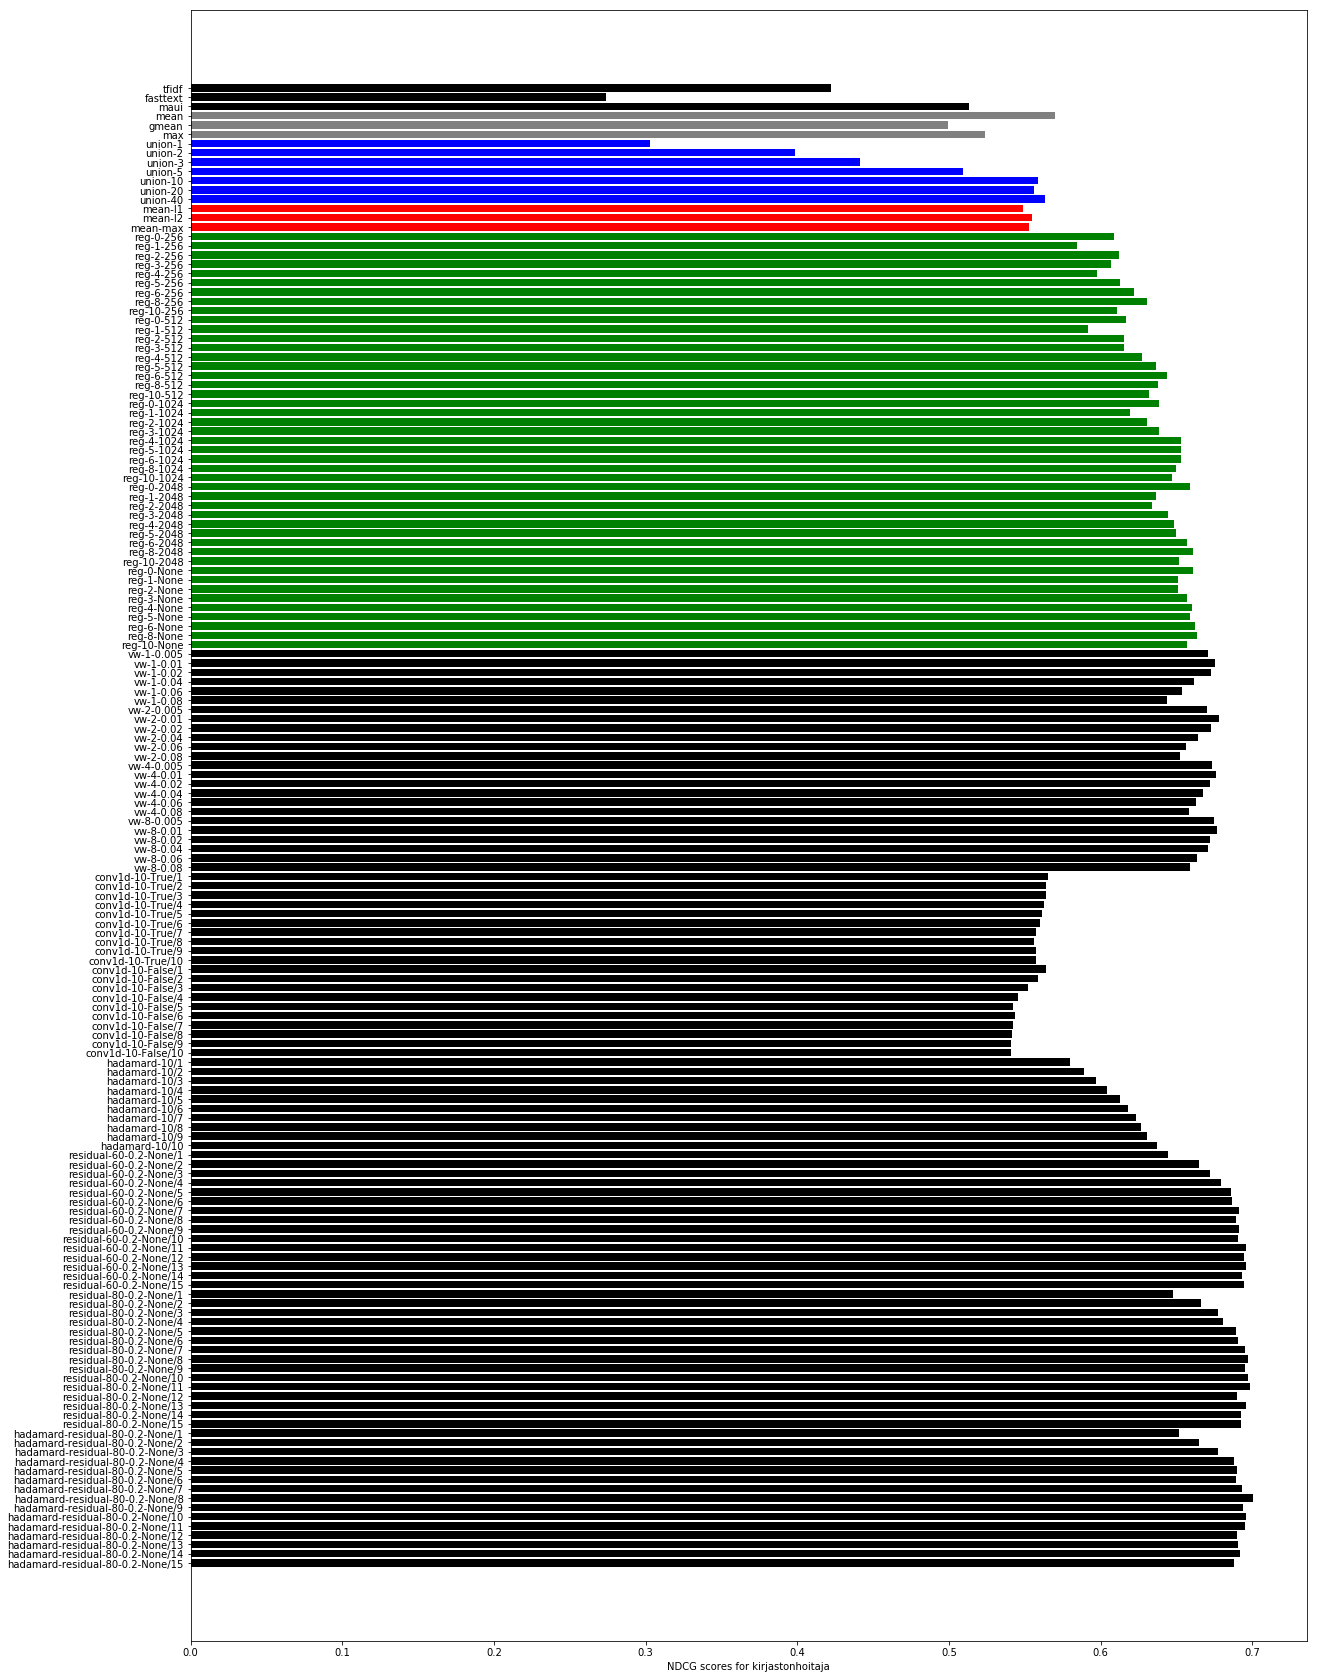

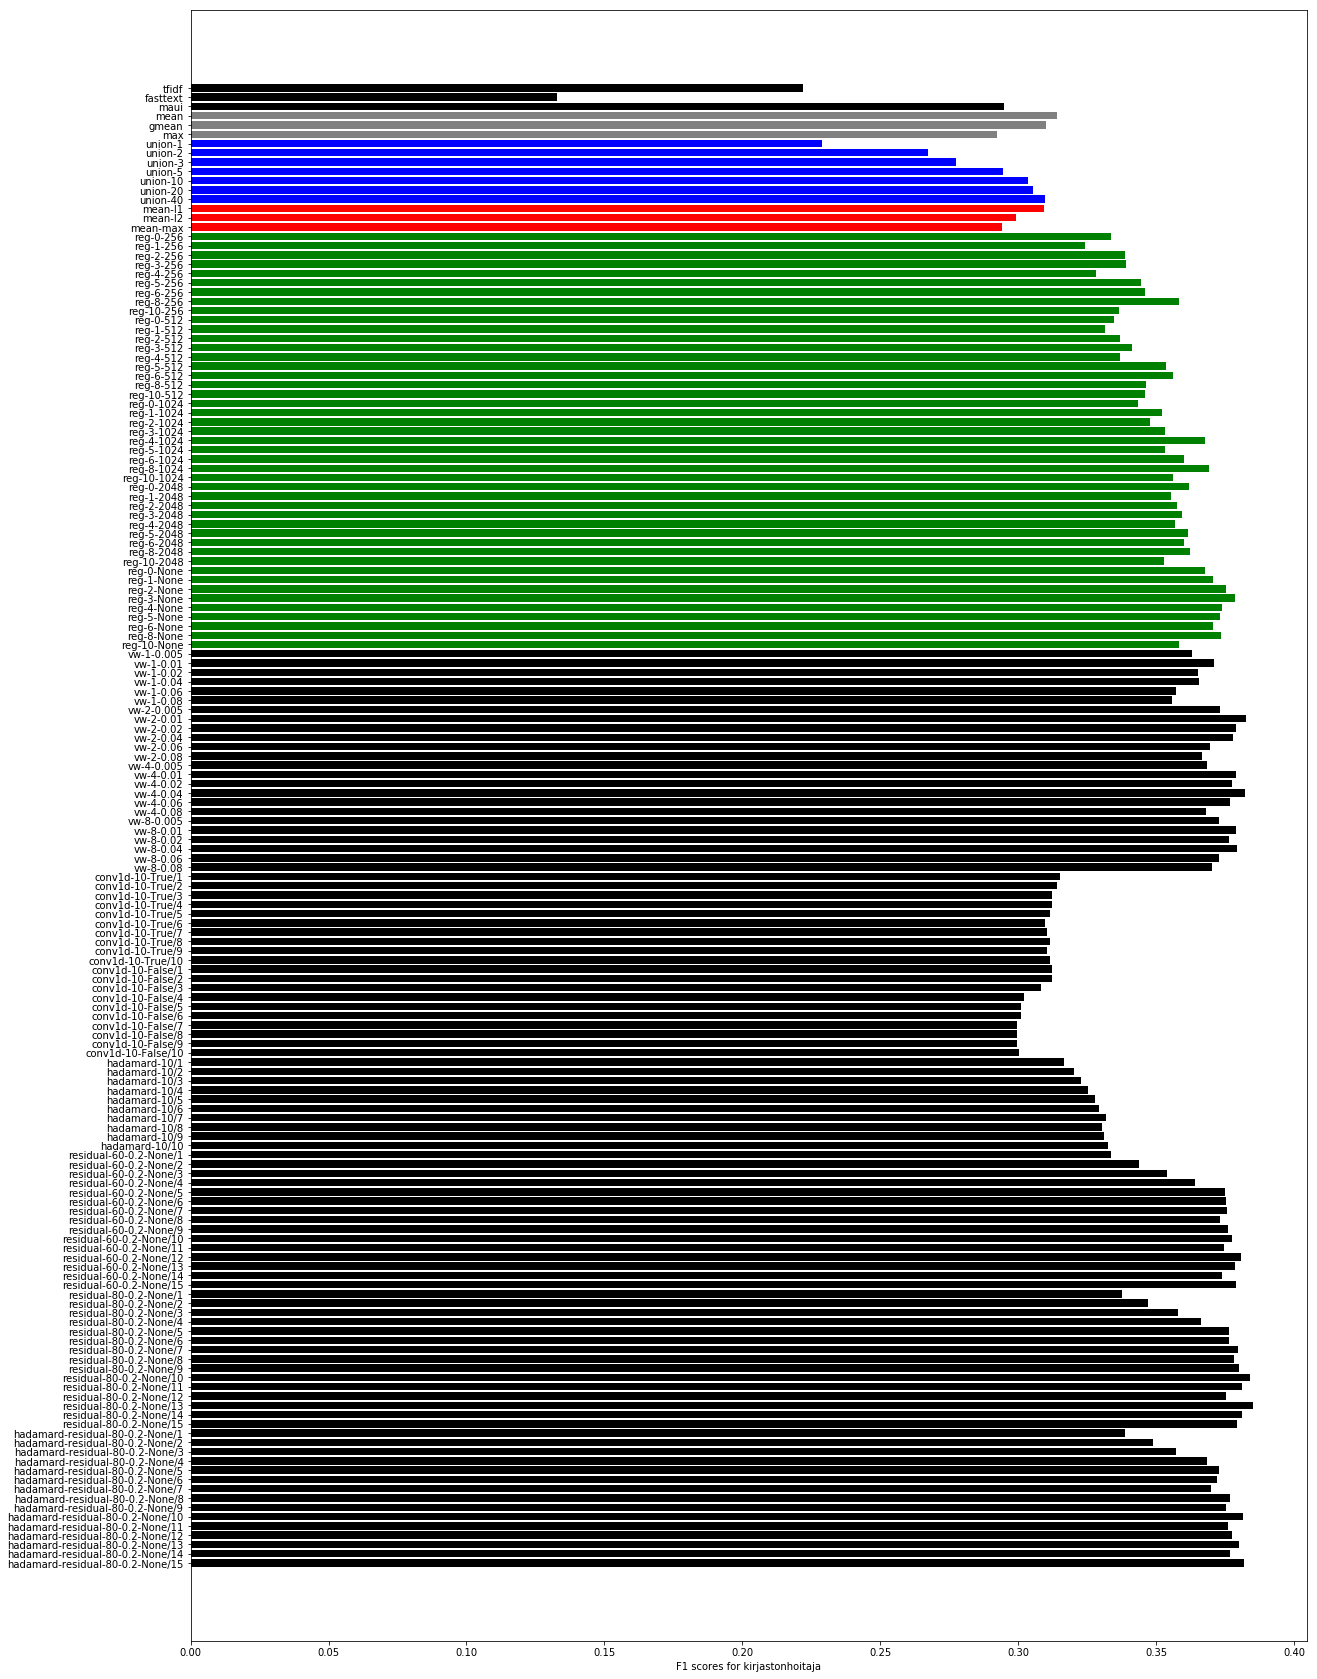

In [34]:
plot('kirjastonhoitaja', 'NDCG')
plot('kirjastonhoitaja', 'F1')

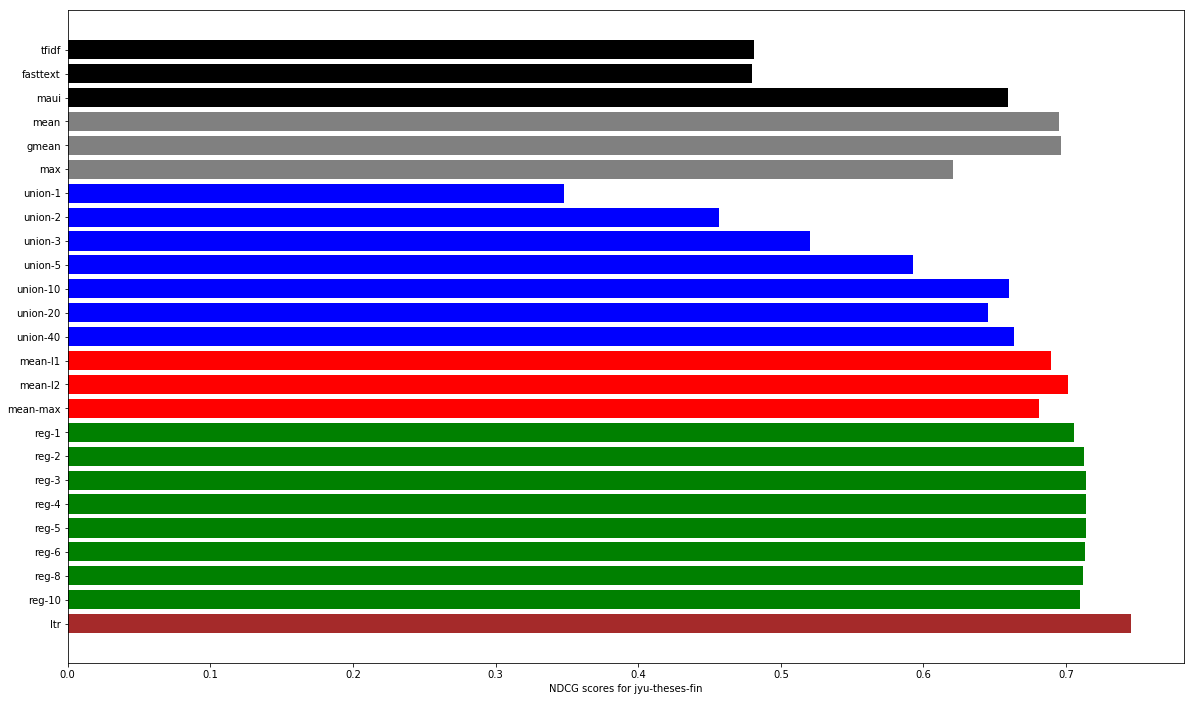

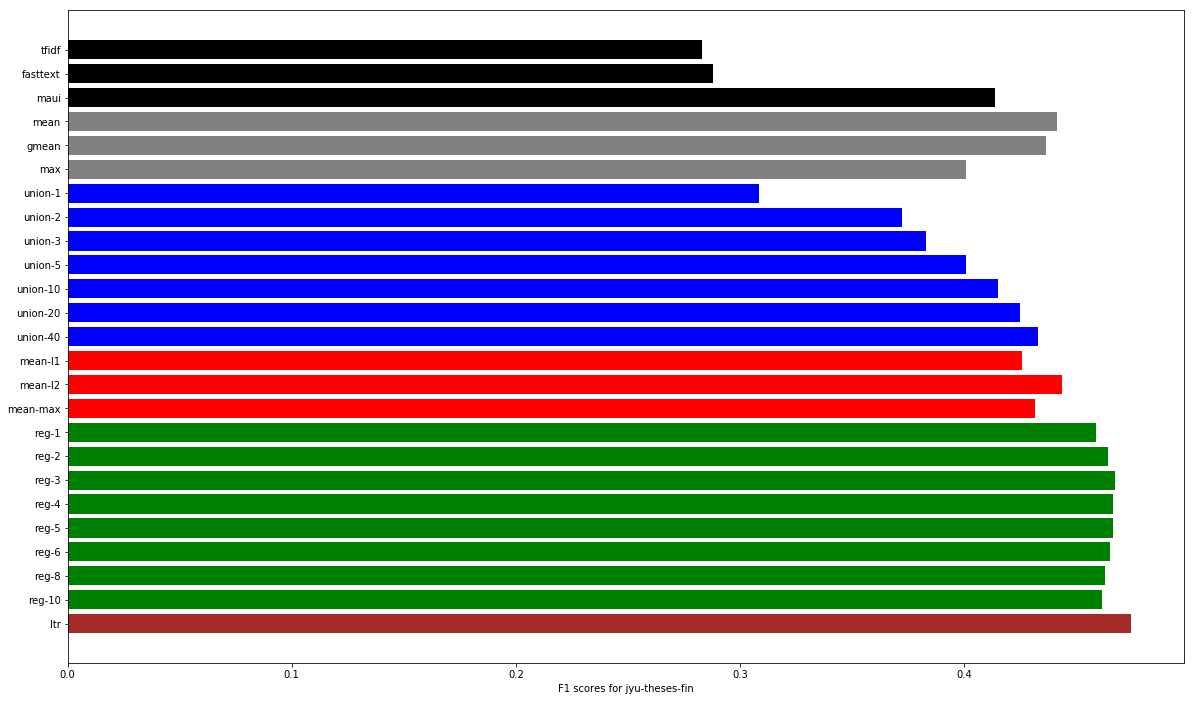

In [35]:
plot('jyu-theses-fin', 'NDCG')
plot('jyu-theses-fin', 'F1')

## Some conclusions

* The NDCG and F1 scores seem to be highly correlated. Generally, attaining a higher NDCG score also implies a high F1 score. Optimizing NDCG, for example via a Learning to Rank method, will also increase F1 scores. This is helpful because NDCG scores can be calculated without setting limits or thresholds in advance.
* When no extra training data is available, using the arithmetic mean of the scores for different algorithm seems like a good strategy. All the other tested fusion methods that did not involve extra training were inferior to arithmetic mean.
* When more training data is available for fine-tuning the fusion, PAV a.k.a. isotonic regression can improve results quite significantly. A good PAV regression model can be built with as few as 3 examples of a particular concept in training data. With fewer than 3 examples of a concept available, using the raw score from the algorithm instead of a PAV-adjusted score works fine. The PAV regression improved F1 scores over the arithmetic mean method by ~6 percentage points for the kirjastonhoitaja data set and ~2.5 percentage points for the jyu-theses data set.
* A Learning to Rank algorithm can be used to further improve result quality but the incremental benefit above PAV appears to be quite small - around 1.0 percentage points in F1 score for the kirjastonhoitaja data set and 0.7 percentage points for the jyu-theses data set. It is not trivial to select the features to use as inputs for LTR nor the hyperparameters of the LTR algorithm. It might be possible to achieve more significant improvements in quality with the right features and parameters, but this requires further experimentation and optimization.
* Only a quantitative evaluation of results has been performed. It would take a qualitative evaluation of results (on a small sample of documents) to determine whether the improvement is meaningful in real world usage.
* The results are encouraging enough to warrant implementing at least the PAV method in Annif, and to start considering also implementing a LTR method.

## Optimizing LTR hyperparameters using hyperopt

It is difficult to know which features and hyperparameters would give the best LTR results. There are so many potential combinations to test that trying each out manually is not a good strategy. One option would be to perform a grid search (scikit-learn provides support for this) and simply test all possible combinations. That may take a lot of CPU time. Another option is random search, which can come up with good combinations in a limited time.

But a third, interesting option is to do an intelligent, partly randomized search that first tries some parameter combinations at random but then narrows the search over time to the most promising parameter combinations. The `hyperopt` module can do this, so let's try to use it.

First we need to define the hyperparameter space: what the parameters are and what their ranges are. Then we need to define a function that takes a combination of parameter values, builds and evaluates a model using those parameters, then returns a loss value that represents how well the model performed (lower score is better). Using those, we can let hyperopt start searching for good parameter value combinations.

In [50]:
%%time

from hyperopt import fmin, tpe, hp, Trials

# how many rounds to try
MAX_EVALS = 100

trials = Trials()

# define the hyperparameters and their types and ranges
spacedef = {
    'lr': hp.loguniform('lr', -4.0, -1.0),  # from 0.05 to 0.368
    'query_subsample': hp.uniform('query_subsample', 0.05, 0.1),
    'max_leaf_nodes': hp.quniform('max_leaf_nodes', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 128, 1)
}


def eval_model(space):
    print("Trial {} of {}".format(len(trials), MAX_EVALS))
    print("Testing values:", space)

    # create a monitor for early stopping and trimming, using validation data
    monitor = pyltr.models.monitors.ValidationMonitor(
        VXall, Vy, Vqids, metric=ndcg_metric, stop_after=50)

    # create a LambdaMART model for learning a suitable ranking
    model = pyltr.models.LambdaMART(
        metric=ndcg_metric,
        n_estimators=1000,
        learning_rate=space['lr'],
        query_subsample=space['query_subsample'],
        max_leaf_nodes=int(space['max_leaf_nodes']),
        min_samples_leaf=int(space['min_samples_leaf']),
    )

    # fit the model to training data
    model.fit(TXall, Ty, Tqids, monitor=monitor)
    
    # extract the best NDCG score from the monitor and return 1 minus the value as the loss
    score = monitor._best_score
    print("NDCG:", score)
    print()
    return (1 - score)

# optimize using hyperopt
best = fmin(fn=eval_model,
           space=spacedef,
           algo=tpe.suggest,
           max_evals=MAX_EVALS,
           trials=trials)

print()
print("Best parameters:", best)
print("Best NDCG:", 1 - trials.best_trial['result']['loss'])

Trial 1 of 100
Testing values: {'lr': 0.07727004054403083, 'max_leaf_nodes': 9.0, 'min_samples_leaf': 37.0, 'query_subsample': 0.08115465085480733}
NDCG: 0.6820655642926311

Trial 2 of 100
Testing values: {'lr': 0.08071266403931156, 'max_leaf_nodes': 13.0, 'min_samples_leaf': 6.0, 'query_subsample': 0.06958523134372892}
NDCG: 0.6789299490161945

Trial 3 of 100
Testing values: {'lr': 0.05220066238333332, 'max_leaf_nodes': 17.0, 'min_samples_leaf': 91.0, 'query_subsample': 0.06461139798559166}
NDCG: 0.6835615981389129

Trial 4 of 100
Testing values: {'lr': 0.19765895703607647, 'max_leaf_nodes': 9.0, 'min_samples_leaf': 128.0, 'query_subsample': 0.09323250289131615}
NDCG: 0.6810351692312708

Trial 5 of 100
Testing values: {'lr': 0.07149398173946579, 'max_leaf_nodes': 7.0, 'min_samples_leaf': 91.0, 'query_subsample': 0.08974181369238175}
NDCG: 0.6838788044869512

Trial 6 of 100
Testing values: {'lr': 0.04780576390108973, 'max_leaf_nodes': 14.0, 'min_samples_leaf': 2.0, 'query_subsample': 0

NDCG: 0.6815170890221898

Trial 48 of 100
Testing values: {'lr': 0.22131100037251455, 'max_leaf_nodes': 16.0, 'min_samples_leaf': 92.0, 'query_subsample': 0.0896096147576313}
NDCG: 0.6730703564751962

Trial 49 of 100
Testing values: {'lr': 0.1465554011856564, 'max_leaf_nodes': 10.0, 'min_samples_leaf': 30.0, 'query_subsample': 0.061356041930757874}
NDCG: 0.6848859241395683

Trial 50 of 100
Testing values: {'lr': 0.16630319018268003, 'max_leaf_nodes': 14.0, 'min_samples_leaf': 40.0, 'query_subsample': 0.08601623786814444}
NDCG: 0.6807010101190281

Trial 51 of 100
Testing values: {'lr': 0.056744041091249954, 'max_leaf_nodes': 18.0, 'min_samples_leaf': 94.0, 'query_subsample': 0.09290889405664486}
NDCG: 0.683033425878756

Trial 52 of 100
Testing values: {'lr': 0.3111613556877278, 'max_leaf_nodes': 19.0, 'min_samples_leaf': 86.0, 'query_subsample': 0.06888957078104012}
NDCG: 0.6749995605369438

Trial 53 of 100
Testing values: {'lr': 0.07323939392505341, 'max_leaf_nodes': 9.0, 'min_samples_

NDCG: 0.6858428757618011

Trial 95 of 100
Testing values: {'lr': 0.03050652245487579, 'max_leaf_nodes': 8.0, 'min_samples_leaf': 47.0, 'query_subsample': 0.08284870034752093}
NDCG: 0.6789233578395846

Trial 96 of 100
Testing values: {'lr': 0.0361420419273396, 'max_leaf_nodes': 6.0, 'min_samples_leaf': 61.0, 'query_subsample': 0.09030446914887937}
NDCG: 0.6902640157347608

Trial 97 of 100
Testing values: {'lr': 0.04068800902790232, 'max_leaf_nodes': 6.0, 'min_samples_leaf': 55.0, 'query_subsample': 0.09779926976055814}
NDCG: 0.6831363493203426

Trial 98 of 100
Testing values: {'lr': 0.03572735543231572, 'max_leaf_nodes': 2.0, 'min_samples_leaf': 61.0, 'query_subsample': 0.08544061398404186}
NDCG: 0.6634261476684525

Trial 99 of 100
Testing values: {'lr': 0.02945323736829866, 'max_leaf_nodes': 4.0, 'min_samples_leaf': 58.0, 'query_subsample': 0.09309789237213731}
NDCG: 0.6847614793024124

Trial 100 of 100
Testing values: {'lr': 0.023761706538744775, 'max_leaf_nodes': 5.0, 'min_samples_le